# Tensorflow Object Detection API and AWS Sagemaker

In this notebook, you will train and evaluate different models using the [Tensorflow Object Detection API](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/) and [AWS Sagemaker](https://aws.amazon.com/sagemaker/). 

If you ever feel stuck, you can refer to this [tutorial](https://aws.amazon.com/blogs/machine-learning/training-and-deploying-models-using-tensorflow-2-with-the-object-detection-api-on-amazon-sagemaker/).

## Dataset

We are using the [Waymo Open Dataset](https://waymo.com/open/) for this project. The dataset has already been exported using the tfrecords format. The files have been created following the format described [here](https://tensorflow-object-detection-api-tutorial.readthedocs.io/en/latest/training.html#create-tensorflow-records). You can find data stored on [AWS S3](https://aws.amazon.com/s3/), AWS Object Storage. The images are saved with a resolution of 640x640.

In [1]:
%%capture
%pip install tensorflow_io sagemaker -U

In [2]:
import os
import sagemaker
from sagemaker.estimator import Estimator
from framework import CustomFramework

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


Save the IAM role in a variable called `role`. This would be useful when training the model.

In [3]:
role = sagemaker.get_execution_role()
print(role)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
arn:aws:iam::339840815706:role/service-role/AmazonSageMaker-ExecutionRole-20231111T220972


In [4]:
# The train and val paths below are public S3 buckets created by Udacity for this project
inputs = {'train': 's3://cd2688-object-detection-tf2/train/', 
          'val': 's3://cd2688-object-detection-tf2/val/'} 

# Insert path of a folder in your personal S3 bucket to store tensorboard logs.
tensorboard_s3_prefix = 's3://jludacity-object-detection-project/logs/'

To view the content of the training datasets, use the following:

`https://s3.console.aws.amazon.com/s3/buckets/cd2688-object-detection-tf2`

## Container

To train the model, you will first need to build a [docker](https://www.docker.com/) container with all the dependencies required by the TF Object Detection API. The code below does the following:
* clone the Tensorflow models repository
* get the exporter and training scripts from the repository
* build the docker image and push it 
* print the container name

In [5]:
%%bash

# clone the repo and get the scripts
git clone https://github.com/tensorflow/models.git docker/models

# get model_main and exporter_main files from TF2 Object Detection GitHub repository
cp docker/models/research/object_detection/exporter_main_v2.py source_dir 
cp docker/models/research/object_detection/model_main_tf2.py source_dir

fatal: destination path 'docker/models' already exists and is not an empty directory.


In [6]:
# build and push the docker image. This code can be commented out after being run once.
# This will take around 10 mins.
image_name = 'tf2-object-detection'
#!sh ./docker/build_and_push.sh $image_name

To verify that the image was correctly pushed to the [Elastic Container Registry](https://aws.amazon.com/ecr/), you can look at it in the AWS webapp. For example, below you can see that three different images have been pushed to ECR. You should only see one, called `tf2-object-detection`.
![ECR Example](../data/example_ecr.png)


In [7]:
# display the container name
with open (os.path.join('docker', 'ecr_image_fullname.txt'), 'r') as f:
    container = f.readlines()[0][:-1]

print(container)

339840815706.dkr.ecr.us-east-1.amazonaws.com/tf2-object-detection:20231113010921


## Pre-trained model from model zoo

As often, we are not training from scratch and we will be using a pretrained model from the TF Object Detection model zoo. You can find pretrained checkpoints [here](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/tf2_detection_zoo.md). Because your time is limited for this project, we recommend to only experiment with the following models:
* SSD MobileNet V2 FPNLite 640x640	
* SSD ResNet50 V1 FPN 640x640 (RetinaNet50)	
* Faster R-CNN ResNet50 V1 640x640	
* EfficientDet D1 640x640	
* Faster R-CNN ResNet152 V1 640x640	

In the code below, the EfficientDet D1 model is downloaded and extracted. This code should be adjusted if you were to experiment with other architectures.

In [18]:
%%bash
mkdir /tmp/checkpoint

mkdir source_dir/checkpoint-efficientdet
wget -O /tmp/efficientdet.tar.gz http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d1_coco17_tpu-32.tar.gz
tar -zxvf /tmp/efficientdet.tar.gz --strip-components 2 --directory source_dir/checkpoint-efficientdet efficientdet_d1_coco17_tpu-32/checkpoint

mkdir source_dir/checkpoint-fasterrcnn
wget -O /tmp/faster_rcnn_resnet50_v1_640x640.tar.gz http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz
tar -zxvf /tmp/faster_rcnn_resnet50_v1_640x640.tar.gz --strip-components 2 --directory source_dir/checkpoint-fasterrcnn faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint

mkdir source_dir/checkpoint-ssdmobilenet
wget -O /tmp/ssd_mobilenet_v2.tar.gz http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
tar -zxvf /tmp/ssd_mobilenet_v2.tar.gz --strip-components 2 --directory source_dir/checkpoint-ssdmobilenet ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint

mkdir: cannot create directory ‘/tmp/checkpoint’: File exists
--2023-11-13 05:52:39--  http://download.tensorflow.org/models/object_detection/tf2/20200711/efficientdet_d1_coco17_tpu-32.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.167.207, 142.251.16.207, 172.253.62.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.167.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 51839363 (49M) [application/x-tar]
Saving to: ‘/tmp/efficientdet.tar.gz’

     0K .......... .......... .......... .......... ..........  0% 13.1M 4s
    50K .......... .......... .......... .......... ..........  0% 27.7M 3s
   100K .......... .......... .......... .......... ..........  0% 22.5M 3s
   150K .......... .......... .......... .......... ..........  0% 72.9M 2s
   200K .......... .......... .......... .......... ..........  0%  108M 2s
   250K .......... .......... .......... .......... ..........  0% 64.3M 2s
   300K .

  5050K .......... .......... .......... .......... .......... 10%  222M 1s
  5100K .......... .......... .......... .......... .......... 10%  530M 1s
  5150K .......... .......... .......... .......... .......... 10%  549M 1s
  5200K .......... .......... .......... .......... .......... 10%  327M 1s
  5250K .......... .......... .......... .......... .......... 10%  201M 1s
  5300K .......... .......... .......... .......... .......... 10%  525M 1s
  5350K .......... .......... .......... .......... .......... 10%  560M 1s
  5400K .......... .......... .......... .......... .......... 10%  368M 1s
  5450K .......... .......... .......... .......... .......... 10%  173M 1s
  5500K .......... .......... .......... .......... .......... 10%  519M 1s
  5550K .......... .......... .......... .......... .......... 11%  413M 1s
  5600K .......... .......... .......... .......... .......... 11%  161M 1s
  5650K .......... .......... .......... .......... .......... 11%  519M 1s
  5700K ....

 10450K .......... .......... .......... .......... .......... 20%  309M 0s
 10500K .......... .......... .......... .......... .......... 20%  159M 0s
 10550K .......... .......... .......... .......... .......... 20%  424M 0s
 10600K .......... .......... .......... .......... .......... 21%  419M 0s
 10650K .......... .......... .......... .......... .......... 21%  139M 0s
 10700K .......... .......... .......... .......... .......... 21%  492M 0s
 10750K .......... .......... .......... .......... .......... 21%  438M 0s
 10800K .......... .......... .......... .......... .......... 21%  153M 0s
 10850K .......... .......... .......... .......... .......... 21%  222M 0s
 10900K .......... .......... .......... .......... .......... 21%  481M 0s
 10950K .......... .......... .......... .......... .......... 21%  433M 0s
 11000K .......... .......... .......... .......... .......... 21%  503M 0s
 11050K .......... .......... .......... .......... .......... 21%  109M 0s
 11100K ....

 15850K .......... .......... .......... .......... .......... 31%  246M 0s
 15900K .......... .......... .......... .......... .......... 31%  189M 0s
 15950K .......... .......... .......... .......... .......... 31%  158M 0s
 16000K .......... .......... .......... .......... .......... 31%  278M 0s
 16050K .......... .......... .......... .......... .......... 31%  220M 0s
 16100K .......... .......... .......... .......... .......... 31%  232M 0s
 16150K .......... .......... .......... .......... .......... 32%  161M 0s
 16200K .......... .......... .......... .......... .......... 32%  229M 0s
 16250K .......... .......... .......... .......... .......... 32%  263M 0s
 16300K .......... .......... .......... .......... .......... 32%  222M 0s
 16350K .......... .......... .......... .......... .......... 32%  188M 0s
 16400K .......... .......... .......... .......... .......... 32%  225M 0s
 16450K .......... .......... .......... .......... .......... 32%  353M 0s
 16500K ....

 21250K .......... .......... .......... .......... .......... 42%  230M 0s
 21300K .......... .......... .......... .......... .......... 42%  235M 0s
 21350K .......... .......... .......... .......... .......... 42%  164M 0s
 21400K .......... .......... .......... .......... .......... 42%  298M 0s
 21450K .......... .......... .......... .......... .......... 42%  185M 0s
 21500K .......... .......... .......... .......... .......... 42%  168M 0s
 21550K .......... .......... .......... .......... .......... 42%  239M 0s
 21600K .......... .......... .......... .......... .......... 42%  501M 0s
 21650K .......... .......... .......... .......... .......... 42%  326M 0s
 21700K .......... .......... .......... .......... .......... 42%  199M 0s
 21750K .......... .......... .......... .......... .......... 43%  172M 0s
 21800K .......... .......... .......... .......... .......... 43%  215M 0s
 21850K .......... .......... .......... .......... .......... 43%  183M 0s
 21900K ....

 26650K .......... .......... .......... .......... .......... 52%  351M 0s
 26700K .......... .......... .......... .......... .......... 52%  308M 0s
 26750K .......... .......... .......... .......... .......... 52%  211M 0s
 26800K .......... .......... .......... .......... .......... 53%  439M 0s
 26850K .......... .......... .......... .......... .......... 53%  256M 0s
 26900K .......... .......... .......... .......... .......... 53%  285M 0s
 26950K .......... .......... .......... .......... .......... 53%  227M 0s
 27000K .......... .......... .......... .......... .......... 53%  367M 0s
 27050K .......... .......... .......... .......... .......... 53%  370M 0s
 27100K .......... .......... .......... .......... .......... 53%  289M 0s
 27150K .......... .......... .......... .......... .......... 53%  216M 0s
 27200K .......... .......... .......... .......... .......... 53%  295M 0s
 27250K .......... .......... .......... .......... .......... 53%  408M 0s
 27300K ....

 32050K .......... .......... .......... .......... .......... 63%  308M 0s
 32100K .......... .......... .......... .......... .......... 63%  466M 0s
 32150K .......... .......... .......... .......... .......... 63%  264M 0s
 32200K .......... .......... .......... .......... .......... 63%  401M 0s
 32250K .......... .......... .......... .......... .......... 63%  295M 0s
 32300K .......... .......... .......... .......... .......... 63%  480M 0s
 32350K .......... .......... .......... .......... .......... 64%  316M 0s
 32400K .......... .......... .......... .......... .......... 64%  486M 0s
 32450K .......... .......... .......... .......... .......... 64%  259M 0s
 32500K .......... .......... .......... .......... .......... 64%  267M 0s
 32550K .......... .......... .......... .......... .......... 64%  409M 0s
 32600K .......... .......... .......... .......... .......... 64%  312M 0s
 32650K .......... .......... .......... .......... .......... 64%  486M 0s
 32700K ....

 37450K .......... .......... .......... .......... .......... 74%  262M 0s
 37500K .......... .......... .......... .......... .......... 74%  256M 0s
 37550K .......... .......... .......... .......... .......... 74%  411M 0s
 37600K .......... .......... .......... .......... .......... 74%  329M 0s
 37650K .......... .......... .......... .......... .......... 74%  477M 0s
 37700K .......... .......... .......... .......... .......... 74%  273M 0s
 37750K .......... .......... .......... .......... .......... 74%  430M 0s
 37800K .......... .......... .......... .......... .......... 74%  338M 0s
 37850K .......... .......... .......... .......... .......... 74%  394M 0s
 37900K .......... .......... .......... .......... .......... 74%  314M 0s
 37950K .......... .......... .......... .......... .......... 75%  258M 0s
 38000K .......... .......... .......... .......... .......... 75%  462M 0s
 38050K .......... .......... .......... .......... .......... 75%  291M 0s
 38100K ....

 42850K .......... .......... .......... .......... .......... 84%  459M 0s
 42900K .......... .......... .......... .......... .......... 84%  256M 0s
 42950K .......... .......... .......... .......... .......... 84%  330M 0s
 43000K .......... .......... .......... .......... .......... 85%  472M 0s
 43050K .......... .......... .......... .......... .......... 85%  258M 0s
 43100K .......... .......... .......... .......... .......... 85%  450M 0s
 43150K .......... .......... .......... .......... .......... 85%  323M 0s
 43200K .......... .......... .......... .......... .......... 85%  487M 0s
 43250K .......... .......... .......... .......... .......... 85%  257M 0s
 43300K .......... .......... .......... .......... .......... 85%  484M 0s
 43350K .......... .......... .......... .......... .......... 85%  301M 0s
 43400K .......... .......... .......... .......... .......... 85%  504M 0s
 43450K .......... .......... .......... .......... .......... 85%  264M 0s
 43500K ....

 48250K .......... .......... .......... .......... .......... 95%  497M 0s
 48300K .......... .......... .......... .......... .......... 95%  434M 0s
 48350K .......... .......... .......... .......... .......... 95%  375M 0s
 48400K .......... .......... .......... .......... .......... 95%  484M 0s
 48450K .......... .......... .......... .......... .......... 95%  443M 0s
 48500K .......... .......... .......... .......... .......... 95%  502M 0s
 48550K .......... .......... .......... .......... .......... 96%  426M 0s
 48600K .......... .......... .......... .......... .......... 96%  435M 0s
 48650K .......... .......... .......... .......... .......... 96%  496M 0s
 48700K .......... .......... .......... .......... .......... 96%  481M 0s
 48750K .......... .......... .......... .......... .......... 96%  417M 0s
 48800K .......... .......... .......... .......... .......... 96%  462M 0s
 48850K .......... .......... .......... .......... .......... 96%  502M 0s
 48900K ....

efficientdet_d1_coco17_tpu-32/checkpoint/ckpt-0.data-00000-of-00001
efficientdet_d1_coco17_tpu-32/checkpoint/checkpoint
efficientdet_d1_coco17_tpu-32/checkpoint/ckpt-0.index


--2023-11-13 05:52:40--  http://download.tensorflow.org/models/object_detection/tf2/20200711/faster_rcnn_resnet50_v1_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.250.31.207, 172.253.63.207, 172.253.122.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.250.31.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211996178 (202M) [application/x-tar]
Saving to: ‘/tmp/faster_rcnn_resnet50_v1_640x640.tar.gz’

     0K .......... .......... .......... .......... ..........  0% 11.2M 18s
    50K .......... .......... .......... .......... ..........  0% 22.2M 14s
   100K .......... .......... .......... .......... ..........  0% 22.6M 12s
   150K .......... .......... .......... .......... ..........  0% 16.3M 12s
   200K .......... .......... .......... .......... ..........  0% 22.6M 11s
   250K .......... .......... .......... .......... ..........  0% 20.9M 11s
   300K .......... .......... 

  5050K .......... .......... .......... .......... ..........  2% 75.8M 5s
  5100K .......... .......... .......... .......... ..........  2%  381M 5s
  5150K .......... .......... .......... .......... ..........  2% 57.7M 5s
  5200K .......... .......... .......... .......... ..........  2% 58.4M 5s
  5250K .......... .......... .......... .......... ..........  2% 56.9M 5s
  5300K .......... .......... .......... .......... ..........  2% 60.6M 5s
  5350K .......... .......... .......... .......... ..........  2%  391M 5s
  5400K .......... .......... .......... .......... ..........  2% 60.5M 5s
  5450K .......... .......... .......... .......... ..........  2% 56.5M 5s
  5500K .......... .......... .......... .......... ..........  2% 47.2M 5s
  5550K .......... .......... .......... .......... ..........  2% 75.6M 5s
  5600K .......... .......... .......... .......... ..........  2%  446M 5s
  5650K .......... .......... .......... .......... ..........  2% 46.9M 5s
  5700K ....

 10450K .......... .......... .......... .......... ..........  5%  407M 4s
 10500K .......... .......... .......... .......... ..........  5% 88.8M 4s
 10550K .......... .......... .......... .......... ..........  5% 80.3M 4s
 10600K .......... .......... .......... .......... ..........  5% 90.5M 4s
 10650K .......... .......... .......... .......... ..........  5% 59.7M 4s
 10700K .......... .......... .......... .......... ..........  5%  498M 4s
 10750K .......... .......... .......... .......... ..........  5%  131M 4s
 10800K .......... .......... .......... .......... ..........  5% 75.4M 3s
 10850K .......... .......... .......... .......... ..........  5% 97.3M 3s
 10900K .......... .......... .......... .......... ..........  5% 62.1M 3s
 10950K .......... .......... .......... .......... ..........  5%  575M 3s
 11000K .......... .......... .......... .......... ..........  5%  115M 3s
 11050K .......... .......... .......... .......... ..........  5% 66.5M 3s
 11100K ....

 15850K .......... .......... .......... .......... ..........  7%  257M 3s
 15900K .......... .......... .......... .......... ..........  7%  100M 3s
 15950K .......... .......... .......... .......... ..........  7% 98.0M 3s
 16000K .......... .......... .......... .......... ..........  7%  135M 3s
 16050K .......... .......... .......... .......... ..........  7%  117M 3s
 16100K .......... .......... .......... .......... ..........  7%  266M 3s
 16150K .......... .......... .......... .......... ..........  7%  114M 3s
 16200K .......... .......... .......... .......... ..........  7% 98.7M 3s
 16250K .......... .......... .......... .......... ..........  7%  130M 3s
 16300K .......... .......... .......... .......... ..........  7%  340M 3s
 16350K .......... .......... .......... .......... ..........  7%  108M 3s
 16400K .......... .......... .......... .......... ..........  7%  112M 3s
 16450K .......... .......... .......... .......... ..........  7%  117M 3s
 16500K ....

 21250K .......... .......... .......... .......... .......... 10%  143M 2s
 21300K .......... .......... .......... .......... .......... 10%  212M 2s
 21350K .......... .......... .......... .......... .......... 10%  213M 2s
 21400K .......... .......... .......... .......... .......... 10%  125M 2s
 21450K .......... .......... .......... .......... .......... 10%  205M 2s
 21500K .......... .......... .......... .......... .......... 10%  171M 2s
 21550K .......... .......... .......... .......... .......... 10%  147M 2s
 21600K .......... .......... .......... .......... .......... 10%  177M 2s
 21650K .......... .......... .......... .......... .......... 10%  148M 2s
 21700K .......... .......... .......... .......... .......... 10%  222M 2s
 21750K .......... .......... .......... .......... .......... 10%  176M 2s
 21800K .......... .......... .......... .......... .......... 10%  156M 2s
 21850K .......... .......... .......... .......... .......... 10%  178M 2s
 21900K ....

 26650K .......... .......... .......... .......... .......... 12%  315M 2s
 26700K .......... .......... .......... .......... .......... 12%  246M 2s
 26750K .......... .......... .......... .......... .......... 12%  265M 2s
 26800K .......... .......... .......... .......... .......... 12%  212M 2s
 26850K .......... .......... .......... .......... .......... 12%  279M 2s
 26900K .......... .......... .......... .......... .......... 13%  341M 2s
 26950K .......... .......... .......... .......... .......... 13%  285M 2s
 27000K .......... .......... .......... .......... .......... 13%  217M 2s
 27050K .......... .......... .......... .......... .......... 13%  255M 2s
 27100K .......... .......... .......... .......... .......... 13%  196M 2s
 27150K .......... .......... .......... .......... .......... 13%  311M 2s
 27200K .......... .......... .......... .......... .......... 13%  175M 2s
 27250K .......... .......... .......... .......... .......... 13%  344M 2s
 27300K ....

 32050K .......... .......... .......... .......... .......... 15%  388M 2s
 32100K .......... .......... .......... .......... .......... 15%  452M 2s
 32150K .......... .......... .......... .......... .......... 15%  534M 2s
 32200K .......... .......... .......... .......... .......... 15%  434M 2s
 32250K .......... .......... .......... .......... .......... 15%  385M 2s
 32300K .......... .......... .......... .......... .......... 15%  463M 2s
 32350K .......... .......... .......... .......... .......... 15%  515M 2s
 32400K .......... .......... .......... .......... .......... 15%  463M 2s
 32450K .......... .......... .......... .......... .......... 15%  368M 2s
 32500K .......... .......... .......... .......... .......... 15%  479M 2s
 32550K .......... .......... .......... .......... .......... 15%  505M 2s
 32600K .......... .......... .......... .......... .......... 15%  326M 2s
 32650K .......... .......... .......... .......... .......... 15%  519M 2s
 32700K ....

 37450K .......... .......... .......... .......... .......... 18%  292M 2s
 37500K .......... .......... .......... .......... .......... 18%  370M 2s
 37550K .......... .......... .......... .......... .......... 18%  498M 2s
 37600K .......... .......... .......... .......... .......... 18%  452M 2s
 37650K .......... .......... .......... .......... .......... 18%  512M 2s
 37700K .......... .......... .......... .......... .......... 18%  504M 2s
 37750K .......... .......... .......... .......... .......... 18%  512M 2s
 37800K .......... .......... .......... .......... .......... 18%  452M 2s
 37850K .......... .......... .......... .......... .......... 18%  511M 2s
 37900K .......... .......... .......... .......... .......... 18%  520M 2s
 37950K .......... .......... .......... .......... .......... 18%  511M 2s
 38000K .......... .......... .......... .......... .......... 18%  450M 2s
 38050K .......... .......... .......... .......... .......... 18%  524M 2s
 38100K ....

 42850K .......... .......... .......... .......... .......... 20%  456M 2s
 42900K .......... .......... .......... .......... .......... 20%  508M 1s
 42950K .......... .......... .......... .......... .......... 20%  228M 1s
 43000K .......... .......... .......... .......... .......... 20%  200M 1s
 43050K .......... .......... .......... .......... .......... 20%  303M 1s
 43100K .......... .......... .......... .......... .......... 20%  489M 1s
 43150K .......... .......... .......... .......... .......... 20%  516M 1s
 43200K .......... .......... .......... .......... .......... 20%  205M 1s
 43250K .......... .......... .......... .......... .......... 20%  475M 1s
 43300K .......... .......... .......... .......... .......... 20%  496M 1s
 43350K .......... .......... .......... .......... .......... 20%  323M 1s
 43400K .......... .......... .......... .......... .......... 20%  288M 1s
 43450K .......... .......... .......... .......... .......... 21%  515M 1s
 43500K ....

 48250K .......... .......... .......... .......... .......... 23%  421M 1s
 48300K .......... .......... .......... .......... .......... 23%  495M 1s
 48350K .......... .......... .......... .......... .......... 23%  449M 1s
 48400K .......... .......... .......... .......... .......... 23%  426M 1s
 48450K .......... .......... .......... .......... .......... 23%  489M 1s
 48500K .......... .......... .......... .......... .......... 23%  444M 1s
 48550K .......... .......... .......... .......... .......... 23%  500M 1s
 48600K .......... .......... .......... .......... .......... 23%  424M 1s
 48650K .......... .......... .......... .......... .......... 23%  516M 1s
 48700K .......... .......... .......... .......... .......... 23%  454M 1s
 48750K .......... .......... .......... .......... .......... 23%  504M 1s
 48800K .......... .......... .......... .......... .......... 23%  384M 1s
 48850K .......... .......... .......... .......... .......... 23%  513M 1s
 48900K ....

 53650K .......... .......... .......... .......... .......... 25%  358M 1s
 53700K .......... .......... .......... .......... .......... 25%  286M 1s
 53750K .......... .......... .......... .......... .......... 25%  334M 1s
 53800K .......... .......... .......... .......... .......... 26%  204M 1s
 53850K .......... .......... .......... .......... .......... 26%  224M 1s
 53900K .......... .......... .......... .......... .......... 26%  264M 1s
 53950K .......... .......... .......... .......... .......... 26%  259M 1s
 54000K .......... .......... .......... .......... .......... 26%  447M 1s
 54050K .......... .......... .......... .......... .......... 26%  472M 1s
 54100K .......... .......... .......... .......... .......... 26%  420M 1s
 54150K .......... .......... .......... .......... .......... 26%  496M 1s
 54200K .......... .......... .......... .......... .......... 26%  492M 1s
 54250K .......... .......... .......... .......... .......... 26%  483M 1s
 54300K ....

 59050K .......... .......... .......... .......... .......... 28%  250M 1s
 59100K .......... .......... .......... .......... .......... 28%  334M 1s
 59150K .......... .......... .......... .......... .......... 28%  253M 1s
 59200K .......... .......... .......... .......... .......... 28%  279M 1s
 59250K .......... .......... .......... .......... .......... 28%  513M 1s
 59300K .......... .......... .......... .......... .......... 28%  182M 1s
 59350K .......... .......... .......... .......... .......... 28%  495M 1s
 59400K .......... .......... .......... .......... .......... 28%  177M 1s
 59450K .......... .......... .......... .......... .......... 28%  442M 1s
 59500K .......... .......... .......... .......... .......... 28%  229M 1s
 59550K .......... .......... .......... .......... .......... 28%  256M 1s
 59600K .......... .......... .......... .......... .......... 28%  469M 1s
 59650K .......... .......... .......... .......... .......... 28%  247M 1s
 59700K ....

 64450K .......... .......... .......... .......... .......... 31%  219M 1s
 64500K .......... .......... .......... .......... .......... 31%  357M 1s
 64550K .......... .......... .......... .......... .......... 31%  208M 1s
 64600K .......... .......... .......... .......... .......... 31%  404M 1s
 64650K .......... .......... .......... .......... .......... 31%  231M 1s
 64700K .......... .......... .......... .......... .......... 31%  421M 1s
 64750K .......... .......... .......... .......... .......... 31%  210M 1s
 64800K .......... .......... .......... .......... .......... 31%  222M 1s
 64850K .......... .......... .......... .......... .......... 31%  425M 1s
 64900K .......... .......... .......... .......... .......... 31%  174M 1s
 64950K .......... .......... .......... .......... .......... 31%  209M 1s
 65000K .......... .......... .......... .......... .......... 31%  336M 1s
 65050K .......... .......... .......... .......... .......... 31%  302M 1s
 65100K ....

 69850K .......... .......... .......... .......... .......... 33%  173M 1s
 69900K .......... .......... .......... .......... .......... 33%  166M 1s
 69950K .......... .......... .......... .......... .......... 33%  299M 1s
 70000K .......... .......... .......... .......... .......... 33%  182M 1s
 70050K .......... .......... .......... .......... .......... 33%  301M 1s
 70100K .......... .......... .......... .......... .......... 33%  411M 1s
 70150K .......... .......... .......... .......... .......... 33%  464M 1s
 70200K .......... .......... .......... .......... .......... 33%  498M 1s
 70250K .......... .......... .......... .......... .......... 33%  520M 1s
 70300K .......... .......... .......... .......... .......... 33%  446M 1s
 70350K .......... .......... .......... .......... .......... 34%  512M 1s
 70400K .......... .......... .......... .......... .......... 34%  483M 1s
 70450K .......... .......... .......... .......... .......... 34%  512M 1s
 70500K ....

 75250K .......... .......... .......... .......... .......... 36%  413M 1s
 75300K .......... .......... .......... .......... .......... 36%  268M 1s
 75350K .......... .......... .......... .......... .......... 36%  165M 1s
 75400K .......... .......... .......... .......... .......... 36%  227M 1s
 75450K .......... .......... .......... .......... .......... 36%  338M 1s
 75500K .......... .......... .......... .......... .......... 36%  272M 1s
 75550K .......... .......... .......... .......... .......... 36%  484M 1s
 75600K .......... .......... .......... .......... .......... 36%  171M 1s
 75650K .......... .......... .......... .......... .......... 36%  203M 1s
 75700K .......... .......... .......... .......... .......... 36%  314M 1s
 75750K .......... .......... .......... .......... .......... 36%  244M 1s
 75800K .......... .......... .......... .......... .......... 36%  239M 1s
 75850K .......... .......... .......... .......... .......... 36%  258M 1s
 75900K ....

 80650K .......... .......... .......... .......... .......... 38%  301M 1s
 80700K .......... .......... .......... .......... .......... 39%  331M 1s
 80750K .......... .......... .......... .......... .......... 39%  316M 1s
 80800K .......... .......... .......... .......... .......... 39%  307M 1s
 80850K .......... .......... .......... .......... .......... 39%  301M 1s
 80900K .......... .......... .......... .......... .......... 39%  254M 1s
 80950K .......... .......... .......... .......... .......... 39%  505M 1s
 81000K .......... .......... .......... .......... .......... 39%  245M 1s
 81050K .......... .......... .......... .......... .......... 39%  342M 1s
 81100K .......... .......... .......... .......... .......... 39%  290M 1s
 81150K .......... .......... .......... .......... .......... 39%  315M 1s
 81200K .......... .......... .......... .......... .......... 39%  328M 1s
 81250K .......... .......... .......... .......... .......... 39%  321M 1s
 81300K ....

 86050K .......... .......... .......... .......... .......... 41%  274M 1s
 86100K .......... .......... .......... .......... .......... 41%  250M 1s
 86150K .......... .......... .......... .......... .......... 41%  243M 1s
 86200K .......... .......... .......... .......... .......... 41%  304M 1s
 86250K .......... .......... .......... .......... .......... 41%  294M 1s
 86300K .......... .......... .......... .......... .......... 41%  224M 1s
 86350K .......... .......... .......... .......... .......... 41%  270M 1s
 86400K .......... .......... .......... .......... .......... 41%  307M 1s
 86450K .......... .......... .......... .......... .......... 41%  491M 1s
 86500K .......... .......... .......... .......... .......... 41%  414M 1s
 86550K .......... .......... .......... .......... .......... 41%  249M 1s
 86600K .......... .......... .......... .......... .......... 41%  282M 1s
 86650K .......... .......... .......... .......... .......... 41%  386M 1s
 86700K ....

 91450K .......... .......... .......... .......... .......... 44%  485M 1s
 91500K .......... .......... .......... .......... .......... 44%  423M 1s
 91550K .......... .......... .......... .......... .......... 44%  244M 1s
 91600K .......... .......... .......... .......... .......... 44%  244M 1s
 91650K .......... .......... .......... .......... .......... 44%  378M 1s
 91700K .......... .......... .......... .......... .......... 44%  416M 1s
 91750K .......... .......... .......... .......... .......... 44%  238M 1s
 91800K .......... .......... .......... .......... .......... 44%  266M 1s
 91850K .......... .......... .......... .......... .......... 44%  323M 1s
 91900K .......... .......... .......... .......... .......... 44%  394M 1s
 91950K .......... .......... .......... .......... .......... 44%  484M 1s
 92000K .......... .......... .......... .......... .......... 44%  230M 1s
 92050K .......... .......... .......... .......... .......... 44%  471M 1s
 92100K ....

 96850K .......... .......... .......... .......... .......... 46%  242M 1s
 96900K .......... .......... .......... .......... .......... 46%  415M 1s
 96950K .......... .......... .......... .......... .......... 46%  482M 1s
 97000K .......... .......... .......... .......... .......... 46%  265M 1s
 97050K .......... .......... .......... .......... .......... 46%  466M 1s
 97100K .......... .......... .......... .......... .......... 46%  436M 1s
 97150K .......... .......... .......... .......... .......... 46%  197M 1s
 97200K .......... .......... .......... .......... .......... 46%  301M 1s
 97250K .......... .......... .......... .......... .......... 46%  470M 1s
 97300K .......... .......... .......... .......... .......... 47%  196M 1s
 97350K .......... .......... .......... .......... .......... 47%  260M 1s
 97400K .......... .......... .......... .......... .......... 47%  297M 1s
 97450K .......... .......... .......... .......... .......... 47%  488M 1s
 97500K ....

151600K .......... .......... .......... .......... .......... 73%  659M 0s
151650K .......... .......... .......... .......... .......... 73%  634M 0s
151700K .......... .......... .......... .......... .......... 73%  569M 0s
151750K .......... .......... .......... .......... .......... 73%  647M 0s
151800K .......... .......... .......... .......... .......... 73%  585M 0s
151850K .......... .......... .......... .......... .......... 73%  642M 0s
151900K .......... .......... .......... .......... .......... 73%  511M 0s
151950K .......... .......... .......... .......... .......... 73%  624M 0s
152000K .......... .......... .......... .......... .......... 73%  604M 0s
152050K .......... .......... .......... .......... .......... 73%  634M 0s
152100K .......... .......... .......... .......... .......... 73%  489M 0s
152150K .......... .......... .......... .......... .......... 73%  563M 0s
152200K .......... .......... .......... .......... .......... 73%  727M 0s
152250K ....

157000K .......... .......... .......... .......... .......... 75%  159M 0s
157050K .......... .......... .......... .......... .......... 75%  138M 0s
157100K .......... .......... .......... .......... .......... 75%  151M 0s
157150K .......... .......... .......... .......... .......... 75%  122M 0s
157200K .......... .......... .......... .......... .......... 75%  169M 0s
157250K .......... .......... .......... .......... .......... 75%  170M 0s
157300K .......... .......... .......... .......... .......... 76%  170M 0s
157350K .......... .......... .......... .......... .......... 76%  145M 0s
157400K .......... .......... .......... .......... .......... 76%  198M 0s
157450K .......... .......... .......... .......... .......... 76%  169M 0s
157500K .......... .......... .......... .......... .......... 76%  178M 0s
157550K .......... .......... .......... .......... .......... 76%  126M 0s
157600K .......... .......... .......... .......... .......... 76%  173M 0s
157650K ....

162400K .......... .......... .......... .......... .......... 78%  277M 0s
162450K .......... .......... .......... .......... .......... 78%  447M 0s
162500K .......... .......... .......... .......... .......... 78%  407M 0s
162550K .......... .......... .......... .......... .......... 78%  232M 0s
162600K .......... .......... .......... .......... .......... 78%  304M 0s
162650K .......... .......... .......... .......... .......... 78%  272M 0s
162700K .......... .......... .......... .......... .......... 78%  383M 0s
162750K .......... .......... .......... .......... .......... 78%  202M 0s
162800K .......... .......... .......... .......... .......... 78%  322M 0s
162850K .......... .......... .......... .......... .......... 78%  267M 0s
162900K .......... .......... .......... .......... .......... 78%  425M 0s
162950K .......... .......... .......... .......... .......... 78%  223M 0s
163000K .......... .......... .......... .......... .......... 78%  284M 0s
163050K ....

167800K .......... .......... .......... .......... .......... 81%  304M 0s
167850K .......... .......... .......... .......... .......... 81%  330M 0s
167900K .......... .......... .......... .......... .......... 81%  256M 0s
167950K .......... .......... .......... .......... .......... 81%  248M 0s
168000K .......... .......... .......... .......... .......... 81%  341M 0s
168050K .......... .......... .......... .......... .......... 81%  320M 0s
168100K .......... .......... .......... .......... .......... 81%  259M 0s
168150K .......... .......... .......... .......... .......... 81%  262M 0s
168200K .......... .......... .......... .......... .......... 81%  319M 0s
168250K .......... .......... .......... .......... .......... 81%  325M 0s
168300K .......... .......... .......... .......... .......... 81%  264M 0s
168350K .......... .......... .......... .......... .......... 81%  280M 0s
168400K .......... .......... .......... .......... .......... 81%  416M 0s
168450K ....

173200K .......... .......... .......... .......... .......... 83%  273M 0s
173250K .......... .......... .......... .......... .......... 83%  265M 0s
173300K .......... .......... .......... .......... .......... 83%  350M 0s
173350K .......... .......... .......... .......... .......... 83%  318M 0s
173400K .......... .......... .......... .......... .......... 83%  271M 0s
173450K .......... .......... .......... .......... .......... 83%  334M 0s
173500K .......... .......... .......... .......... .......... 83%  278M 0s
173550K .......... .......... .......... .......... .......... 83%  304M 0s
173600K .......... .......... .......... .......... .......... 83%  278M 0s
173650K .......... .......... .......... .......... .......... 83%  414M 0s
173700K .......... .......... .......... .......... .......... 83%  296M 0s
173750K .......... .......... .......... .......... .......... 83%  249M 0s
173800K .......... .......... .......... .......... .......... 83%  293M 0s
173850K ....

178600K .......... .......... .......... .......... .......... 86%  258M 0s
178650K .......... .......... .......... .......... .......... 86%  303M 0s
178700K .......... .......... .......... .......... .......... 86%  301M 0s
178750K .......... .......... .......... .......... .......... 86%  241M 0s
178800K .......... .......... .......... .......... .......... 86%  272M 0s
178850K .......... .......... .......... .......... .......... 86%  267M 0s
178900K .......... .......... .......... .......... .......... 86%  429M 0s
178950K .......... .......... .......... .......... .......... 86%  280M 0s
179000K .......... .......... .......... .......... .......... 86%  453M 0s
179050K .......... .......... .......... .......... .......... 86%  302M 0s
179100K .......... .......... .......... .......... .......... 86%  282M 0s
179150K .......... .......... .......... .......... .......... 86%  266M 0s
179200K .......... .......... .......... .......... .......... 86%  492M 0s
179250K ....

184000K .......... .......... .......... .......... .......... 88%  316M 0s
184050K .......... .......... .......... .......... .......... 88%  271M 0s
184100K .......... .......... .......... .......... .......... 88%  412M 0s
184150K .......... .......... .......... .......... .......... 88%  420M 0s
184200K .......... .......... .......... .......... .......... 88%  321M 0s
184250K .......... .......... .......... .......... .......... 89%  228M 0s
184300K .......... .......... .......... .......... .......... 89%  358M 0s
184350K .......... .......... .......... .......... .......... 89%  406M 0s
184400K .......... .......... .......... .......... .......... 89%  354M 0s
184450K .......... .......... .......... .......... .......... 89%  205M 0s
184500K .......... .......... .......... .......... .......... 89%  244M 0s
184550K .......... .......... .......... .......... .......... 89%  279M 0s
184600K .......... .......... .......... .......... .......... 89%  447M 0s
184650K ....

189400K .......... .......... .......... .......... .......... 91%  319M 0s
189450K .......... .......... .......... .......... .......... 91%  258M 0s
189500K .......... .......... .......... .......... .......... 91%  249M 0s
189550K .......... .......... .......... .......... .......... 91%  248M 0s
189600K .......... .......... .......... .......... .......... 91%  227M 0s
189650K .......... .......... .......... .......... .......... 91%  329M 0s
189700K .......... .......... .......... .......... .......... 91%  233M 0s
189750K .......... .......... .......... .......... .......... 91%  387M 0s
189800K .......... .......... .......... .......... .......... 91%  489M 0s
189850K .......... .......... .......... .......... .......... 91%  214M 0s
189900K .......... .......... .......... .......... .......... 91%  429M 0s
189950K .......... .......... .......... .......... .......... 91%  425M 0s
190000K .......... .......... .......... .......... .......... 91%  274M 0s
190050K ....

194800K .......... .......... .......... .......... .......... 94%  640M 0s
194850K .......... .......... .......... .......... .......... 94%  638M 0s
194900K .......... .......... .......... .......... .......... 94%  734M 0s
194950K .......... .......... .......... .......... .......... 94%  569M 0s
195000K .......... .......... .......... .......... .......... 94%  568M 0s
195050K .......... .......... .......... .......... .......... 94%  516M 0s
195100K .......... .......... .......... .......... .......... 94%  527M 0s
195150K .......... .......... .......... .......... .......... 94%  444M 0s
195200K .......... .......... .......... .......... .......... 94%  573M 0s
195250K .......... .......... .......... .......... .......... 94%  509M 0s
195300K .......... .......... .......... .......... .......... 94%  716M 0s
195350K .......... .......... .......... .......... .......... 94%  542M 0s
195400K .......... .......... .......... .......... .......... 94%  575M 0s
195450K ....

200200K .......... .......... .......... .......... .......... 96%  608M 0s
200250K .......... .......... .......... .......... .......... 96%  573M 0s
200300K .......... .......... .......... .......... .......... 96%  671M 0s
200350K .......... .......... .......... .......... .......... 96%  582M 0s
200400K .......... .......... .......... .......... .......... 96%  663M 0s
200450K .......... .......... .......... .......... .......... 96%  592M 0s
200500K .......... .......... .......... .......... .......... 96%  695M 0s
200550K .......... .......... .......... .......... .......... 96%  574M 0s
200600K .......... .......... .......... .......... .......... 96%  626M 0s
200650K .......... .......... .......... .......... .......... 96%  618M 0s
200700K .......... .......... .......... .......... .......... 96%  638M 0s
200750K .......... .......... .......... .......... .......... 96%  555M 0s
200800K .......... .......... .......... .......... .......... 97%  657M 0s
200850K ....

205600K .......... .......... .......... .......... .......... 99%  576M 0s
205650K .......... .......... .......... .......... .......... 99%  548M 0s
205700K .......... .......... .......... .......... .......... 99%  706M 0s
205750K .......... .......... .......... .......... .......... 99%  321M 0s
205800K .......... .......... .......... .......... .......... 99%  598M 0s
205850K .......... .......... .......... .......... .......... 99%  507M 0s
205900K .......... .......... .......... .......... .......... 99%  432M 0s
205950K .......... .......... .......... .......... .......... 99%  623M 0s
206000K .......... .......... .......... .......... .......... 99%  485M 0s
206050K .......... .......... .......... .......... .......... 99%  203M 0s
206100K .......... .......... .......... .......... .......... 99%  660M 0s
206150K .......... .......... .......... .......... .......... 99%  562M 0s
206200K .......... .......... .......... .......... .......... 99%  564M 0s
206250K ....

faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/checkpoint
faster_rcnn_resnet50_v1_640x640_coco17_tpu-8/checkpoint/ckpt-0.index


--2023-11-13 05:52:45--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 142.251.167.207, 142.250.31.207, 172.253.63.207, ...
Connecting to download.tensorflow.org (download.tensorflow.org)|142.251.167.207|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20518283 (20M) [application/x-tar]
Saving to: ‘/tmp/ssd_mobilenet_v2.tar.gz’

     0K .......... .......... .......... .......... ..........  0% 13.1M 1s
    50K .......... .......... .......... .......... ..........  0% 27.0M 1s
   100K .......... .......... .......... .......... ..........  0% 26.4M 1s
   150K .......... .......... .......... .......... ..........  0% 20.3M 1s
   200K .......... .......... .......... .......... ..........  1% 73.6M 1s
   250K .......... .......... .......... .......... ..........  1% 71.2M 1s
   300K .......... .......... .......... ..........

  5100K .......... .......... .......... .......... .......... 25%  215M 0s
  5150K .......... .......... .......... .......... .......... 25%  125M 0s
  5200K .......... .......... .......... .......... .......... 26%  210M 0s
  5250K .......... .......... .......... .......... .......... 26%  190M 0s
  5300K .......... .......... .......... .......... .......... 26%  249M 0s
  5350K .......... .......... .......... .......... .......... 26%  287M 0s
  5400K .......... .......... .......... .......... .......... 27%  153M 0s
  5450K .......... .......... .......... .......... .......... 27%  200M 0s
  5500K .......... .......... .......... .......... .......... 27%  230M 0s
  5550K .......... .......... .......... .......... .......... 27%  222M 0s
  5600K .......... .......... .......... .......... .......... 28%  208M 0s
  5650K .......... .......... .......... .......... .......... 28%  150M 0s
  5700K .......... .......... .......... .......... .......... 28%  135M 0s
  5750K ....

 10500K .......... .......... .......... .......... .......... 52%  337M 0s
 10550K .......... .......... .......... .......... .......... 52%  328M 0s
 10600K .......... .......... .......... .......... .......... 53%  400M 0s
 10650K .......... .......... .......... .......... .......... 53%  367M 0s
 10700K .......... .......... .......... .......... .......... 53%  351M 0s
 10750K .......... .......... .......... .......... .......... 53%  280M 0s
 10800K .......... .......... .......... .......... .......... 54%  491M 0s
 10850K .......... .......... .......... .......... .......... 54%  246M 0s
 10900K .......... .......... .......... .......... .......... 54%  439M 0s
 10950K .......... .......... .......... .......... .......... 54%  319M 0s
 11000K .......... .......... .......... .......... .......... 55%  303M 0s
 11050K .......... .......... .......... .......... .......... 55%  371M 0s
 11100K .......... .......... .......... .......... .......... 55%  374M 0s
 11150K ....

 15900K .......... .......... .......... .......... .......... 79%  323M 0s
 15950K .......... .......... .......... .......... .......... 79%  439M 0s
 16000K .......... .......... .......... .......... .......... 80%  336M 0s
 16050K .......... .......... .......... .......... .......... 80%  461M 0s
 16100K .......... .......... .......... .......... .......... 80%  271M 0s
 16150K .......... .......... .......... .......... .......... 80%  284M 0s
 16200K .......... .......... .......... .......... .......... 81%  438M 0s
 16250K .......... .......... .......... .......... .......... 81%  307M 0s
 16300K .......... .......... .......... .......... .......... 81%  485M 0s
 16350K .......... .......... .......... .......... .......... 81%  277M 0s
 16400K .......... .......... .......... .......... .......... 82%  519M 0s
 16450K .......... .......... .......... .......... .......... 82%  277M 0s
 16500K .......... .......... .......... .......... .......... 82%  505M 0s
 16550K ....

ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-0.data-00000-of-00001
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/checkpoint
ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint/ckpt-0.index


## Edit pipeline.config file

The [`pipeline.config`](source_dir/pipeline.config) in the `source_dir` folder should be updated when you experiment with different models. The different config files are available [here](https://github.com/tensorflow/models/tree/master/research/object_detection/configs/tf2).

>Note: The provided `pipeline.config` file works well with the `EfficientDet` model. You would need to modify it when working with other models.

## Launch Training Job

Now that we have a dataset, a docker image and some pretrained model weights, we can launch the training job. To do so, we create a [Sagemaker Framework](https://sagemaker.readthedocs.io/en/stable/frameworks/index.html), where we indicate the container name, name of the config file, number of training steps etc.

The `run_training.sh` script does the following:
* train the model for `num_train_steps` 
* evaluate over the val dataset
* export the model

Different metrics will be displayed during the evaluation phase, including the mean average precision. These metrics can be used to quantify your model performances and compare over the different iterations.

You can also monitor the training progress by navigating to **Training -> Training Jobs** from the Amazon Sagemaker dashboard in the Web UI.

In [10]:
# EfficientDet

tensorboard_output_config = sagemaker.debugger.TensorBoardOutputConfig(
    s3_output_path=tensorboard_s3_prefix,
    container_local_output_path='/opt/training/'
)

estimator = CustomFramework(
    role=role,
    image_uri=container,
    entry_point='run_training.sh',
    source_dir='source_dir/',
    hyperparameters={
        "model_dir": "/opt/training",        
        "pipeline_config_path": "pipeline-efficientdet-default.config",
        "num_train_steps": "2000",    
        "sample_1_of_n_eval_examples": "1"
    },
    instance_count=1,
    instance_type='ml.g5.xlarge',
    tensorboard_output_config=tensorboard_output_config,
    disable_profiler=True,
    base_job_name='tf2-object-detection'
)

estimator.fit(inputs)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Using provided s3_resource


INFO:sagemaker:Creating training-job with name: tf2-object-detection-2023-11-13-04-19-12-655


2023-11-13 04:19:22 Starting - Starting the training job...
2023-11-13 04:19:36 Starting - Preparing the instances for training......
2023-11-13 04:20:35 Downloading - Downloading input data...
2023-11-13 04:21:05 Training - Downloading the training image.........
2023-11-13 04:22:51 Training - Training image download completed. Training in progress....2023-11-13 04:23:05,636 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-11-13 04:23:05,664 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-11-13 04:23:05,691 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-11-13 04:23:05,704 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "train": "/opt/ml/input/data/train",
        "val": "/opt/ml/input/data/val"
    },
    "current_host": "algo-1",
    "current_ins

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
W1113 04:23:21.074923 139654719956800 deprecation.py:364] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1176: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use `tf.cast` instead.
W1113 04:23:24.682921 139654719956800 deprecation.py:364] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1176: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
/usr/local/lib/python3.8/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/Fa

INFO:tensorflow:Step 300 per-step time 0.668s
I1113 04:28:21.201938 139654719956800 model_lib_v2.py:705] Step 300 per-step time 0.668s
INFO:tensorflow:{'Loss/classification_loss': 0.29635322,
 'Loss/localization_loss': 0.020651449,
 'Loss/regularization_loss': 0.02954928,
 'Loss/total_loss': 0.34655395,
 'learning_rate': 0.010480001}
I1113 04:28:21.202196 139654719956800 model_lib_v2.py:708] {'Loss/classification_loss': 0.29635322,
 'Loss/localization_loss': 0.020651449,
 'Loss/regularization_loss': 0.02954928,
 'Loss/total_loss': 0.34655395,
 'learning_rate': 0.010480001}
INFO:tensorflow:Step 400 per-step time 0.671s
I1113 04:29:28.342292 139654719956800 model_lib_v2.py:705] Step 400 per-step time 0.671s
INFO:tensorflow:{'Loss/classification_loss': 0.27222303,
 'Loss/localization_loss': 0.018322358,
 'Loss/regularization_loss': 0.029556895,
 'Loss/total_loss': 0.32010227,
 'learning_rate': 0.0136400005}
I1113 04:29:28.342551 139654719956800 model_lib_v2.py:708] {'Loss/classification_l

INFO:tensorflow:Step 1700 per-step time 0.670s
I1113 04:44:02.197977 139654719956800 model_lib_v2.py:705] Step 1700 per-step time 0.670s
INFO:tensorflow:{'Loss/classification_loss': 0.24895371,
 'Loss/localization_loss': 0.012393303,
 'Loss/regularization_loss': 0.030295916,
 'Loss/total_loss': 0.29164293,
 'learning_rate': 0.05472}
I1113 04:44:02.198241 139654719956800 model_lib_v2.py:708] {'Loss/classification_loss': 0.24895371,
 'Loss/localization_loss': 0.012393303,
 'Loss/regularization_loss': 0.030295916,
 'Loss/total_loss': 0.29164293,
 'learning_rate': 0.05472}
INFO:tensorflow:Step 1800 per-step time 0.670s
I1113 04:45:09.201766 139654719956800 model_lib_v2.py:705] Step 1800 per-step time 0.670s
INFO:tensorflow:{'Loss/classification_loss': 0.22850703,
 'Loss/localization_loss': 0.011683928,
 'Loss/regularization_loss': 0.030416908,
 'Loss/total_loss': 0.27060786,
 'learning_rate': 0.05788}
I1113 04:45:09.202034 139654719956800 model_lib_v2.py:708] {'Loss/classification_loss': 0

/usr/local/lib/python3.8/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(
I1113 04:47:48.853994 140145006896960 api.py:460] feature_map_spatial_dims: [(80, 80), (40, 40), (20, 20), (10, 10), (5, 5)]
I1113 04:48:01.951713 140145006896960 api.py:460] feature_map_spatial_dims: [(80, 80), (40, 40), (20, 20), (10, 10), (5, 5)]
Instructions for updating:
Use `tf.cast` instead.
W1113 04:48:07.406617 140145006896960 deprecation.py:364] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1176: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
INFO:tensorflow:Finished eval step 0
I1113 04:48:07.500622 140145006896960 model_lib_v2.py:966] Fin

I1113 04:53:02.531317 140544414607168 api.py:460] feature_map_spatial_dims: [(80, 80), (40, 40), (20, 20), (10, 10), (5, 5)]
I1113 04:53:12.525135 140544414607168 api.py:460] feature_map_spatial_dims: [(80, 80), (40, 40), (20, 20), (10, 10), (5, 5)]
I1113 04:53:15.959548 140544414607168 signature_serialization.py:148] Function `call_func` contains input name(s) resource with unsupported characters which will be renamed to weightsharedconvolutionalboxpredictor_classpredictiontower_conv2d_2_batchnorm_feature_4_fusedbatchnormv3_readvariableop_1_resource in the SavedModel.
I1113 04:53:18.733272 140544414607168 api.py:460] feature_map_spatial_dims: [(80, 80), (40, 40), (20, 20), (10, 10), (5, 5)]
W1113 04:53:20.877830 140544414607168 save_impl.py:66] Skipping full serialization of Keras layer <object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch object at 0x7fd1c9fe6610>, because it is not built.
I1113 04:53:50.514616 140544414607168 save.py:274] Found untraced functions such as We

### Train with Faster R-CNN

Need to decrease batch_size to 8 and change fine_tune_checkpoint_type to detection

In [ ]:
# Faster R-CNN

estimator = CustomFramework(
    role=role,
    image_uri=container,
    entry_point='run_training.sh',
    source_dir='source_dir/',
    hyperparameters={
        "model_dir": "/opt/training",        
        "pipeline_config_path": "pipeline-fasterrcnn.config",
        "num_train_steps": "2000",    
        "sample_1_of_n_eval_examples": "1"
    },
    instance_count=1,
    instance_type='ml.g5.xlarge',
    tensorboard_output_config=tensorboard_output_config,
    disable_profiler=True,
    base_job_name='tf2-object-detection'
)

estimator.fit(inputs)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Using provided s3_resource


INFO:sagemaker:Creating training-job with name: tf2-object-detection-2023-11-13-06-31-26-647


2023-11-13 06:31:34 Starting - Starting the training job...
2023-11-13 06:31:50 Starting - Preparing the instances for training......
2023-11-13 06:33:02 Downloading - Downloading input data...
2023-11-13 06:33:34 Training - Downloading the training image............
2023-11-13 06:35:15 Training - Training image download completed. Training in progress..2023-11-13 06:35:30,819 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-11-13 06:35:30,847 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-11-13 06:35:30,876 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-11-13 06:35:30,889 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "train": "/opt/ml/input/data/train",
        "val": "/opt/ml/input/data/val"
    },
    "current_host": "algo-1",
    "current_in

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
W1113 06:35:43.072360 139666812634944 deprecation.py:364] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1176: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
Use `tf.cast` instead.
W1113 06:35:45.563003 139666812634944 deprecation.py:364] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1176: to_float (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
/usr/local/lib/python3.8/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/Fa

INFO:tensorflow:Step 200 per-step time 0.345s
I1113 06:38:52.721129 139666812634944 model_lib_v2.py:705] Step 200 per-step time 0.345s
INFO:tensorflow:{'Loss/BoxClassifierLoss/classification_loss': 0.34642375,
 'Loss/BoxClassifierLoss/localization_loss': 0.50544316,
 'Loss/RPNLoss/localization_loss': 0.6688144,
 'Loss/RPNLoss/objectness_loss': 0.09592138,
 'Loss/regularization_loss': 0.0,
 'Loss/total_loss': 1.6166027,
 'learning_rate': 0.0159997}
I1113 06:38:52.721392 139666812634944 model_lib_v2.py:708] {'Loss/BoxClassifierLoss/classification_loss': 0.34642375,
 'Loss/BoxClassifierLoss/localization_loss': 0.50544316,
 'Loss/RPNLoss/localization_loss': 0.6688144,
 'Loss/RPNLoss/objectness_loss': 0.09592138,
 'Loss/regularization_loss': 0.0,
 'Loss/total_loss': 1.6166027,
 'learning_rate': 0.0159997}
INFO:tensorflow:Step 300 per-step time 0.344s
I1113 06:39:27.142552 139666812634944 model_lib_v2.py:705] Step 300 per-step time 0.344s
INFO:tensorflow:{'Loss/BoxClassifierLoss/classificati

INFO:tensorflow:Step 1200 per-step time 0.346s
I1113 06:44:38.287994 139666812634944 model_lib_v2.py:705] Step 1200 per-step time 0.346s
INFO:tensorflow:{'Loss/BoxClassifierLoss/classification_loss': 0.19800662,
 'Loss/BoxClassifierLoss/localization_loss': 0.27360612,
 'Loss/RPNLoss/localization_loss': 0.41659173,
 'Loss/RPNLoss/objectness_loss': 0.032209788,
 'Loss/regularization_loss': 0.0,
 'Loss/total_loss': 0.92041427,
 'learning_rate': 0.0293332}
I1113 06:44:38.288249 139666812634944 model_lib_v2.py:708] {'Loss/BoxClassifierLoss/classification_loss': 0.19800662,
 'Loss/BoxClassifierLoss/localization_loss': 0.27360612,
 'Loss/RPNLoss/localization_loss': 0.41659173,
 'Loss/RPNLoss/objectness_loss': 0.032209788,
 'Loss/regularization_loss': 0.0,
 'Loss/total_loss': 0.92041427,
 'learning_rate': 0.0293332}
INFO:tensorflow:Step 1300 per-step time 0.345s
I1113 06:45:12.779642 139666812634944 model_lib_v2.py:705] Step 1300 per-step time 0.345s
INFO:tensorflow:{'Loss/BoxClassifierLoss/cl

/usr/local/lib/python3.8/dist-packages/keras/src/backend.py:452: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn(
INFO:tensorflow:depth of additional conv before box predictor: 0
I1113 06:49:33.925388 140575764309824 convolutional_keras_box_predictor.py:152] depth of additional conv before box predictor: 0
Instructions for updating:
Use ref() instead.
W1113 06:49:40.148135 140575764309824 deprecation.py:364] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/autograph/impl/api.py:460: Tensor.experimental_ref (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use ref() instead.
Instructions for updating:
Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.
See `

### Train with SSD MobileNet v2

Need to decrease batch_size to 8 and change fine_tune_checkpoint_type to detection

In [21]:
# SSD MobileNet V2 FPNLite

estimator = CustomFramework(
    role=role,
    image_uri=container,
    entry_point='run_training.sh',
    source_dir='source_dir/',
    hyperparameters={
        "model_dir": "/opt/training",        
        "pipeline_config_path": "pipeline-ssdmobilenet.config",
        "num_train_steps": "2000",    
        "sample_1_of_n_eval_examples": "1"
    },
    instance_count=1,
    instance_type='ml.g5.xlarge',
    tensorboard_output_config=tensorboard_output_config,
    disable_profiler=True,
    base_job_name='tf2-object-detection'
)

estimator.fit(inputs)

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml
Using provided s3_resource


INFO:sagemaker:Creating training-job with name: tf2-object-detection-2023-11-13-06-09-46-032


2023-11-13 06:09:54 Starting - Starting the training job...
2023-11-13 06:10:09 Starting - Preparing the instances for training......
2023-11-13 06:11:22 Downloading - Downloading input data...
2023-11-13 06:11:50 Training - Downloading the training image............
2023-11-13 06:13:35 Training - Training image download completed. Training in progress..2023-11-13 06:13:49,745 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-11-13 06:13:49,774 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-11-13 06:13:49,801 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2023-11-13 06:13:49,814 sagemaker-training-toolkit INFO     Invoking user script
Training Env:
{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "train": "/opt/ml/input/data/train",
        "val": "/opt/ml/input/data/val"
    },
    "current_host": "algo-1",
    "current_in

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
W1113 06:14:01.893849 139807274583872 deprecation.py:364] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1176: sparse_to_dense (from tensorflow.python.ops.sparse_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
W1113 06:14:04.698756 139807274583872 deprecation.py:364] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1176: sample_distorted_bounding_box (from tensorflow.python.ops.image_ops_impl) is deprecated and will be removed in a future version.
Instructions for updating:
`seed2` arg is deprecated.Use sample_distorted_bounding_box_v2 instead.
Instructions for updating:
Use `tf.cast` instead.
W1113 06:14:06.086062 139807

INFO:tensorflow:Step 300 per-step time 0.262s
I1113 06:16:18.278453 139807274583872 model_lib_v2.py:705] Step 300 per-step time 0.262s
INFO:tensorflow:{'Loss/classification_loss': 0.29111612,
 'Loss/localization_loss': 0.346322,
 'Loss/regularization_loss': 0.15128338,
 'Loss/total_loss': 0.7887215,
 'learning_rate': 0.0426662}
I1113 06:16:18.278701 139807274583872 model_lib_v2.py:708] {'Loss/classification_loss': 0.29111612,
 'Loss/localization_loss': 0.346322,
 'Loss/regularization_loss': 0.15128338,
 'Loss/total_loss': 0.7887215,
 'learning_rate': 0.0426662}
INFO:tensorflow:Step 400 per-step time 0.262s
I1113 06:16:44.454396 139807274583872 model_lib_v2.py:705] Step 400 per-step time 0.262s
INFO:tensorflow:{'Loss/classification_loss': 0.2893844,
 'Loss/localization_loss': 0.35397518,
 'Loss/regularization_loss': 0.15122093,
 'Loss/total_loss': 0.79458046,
 'learning_rate': 0.047999598}
I1113 06:16:44.454640 139807274583872 model_lib_v2.py:708] {'Loss/classification_loss': 0.2893844,

INFO:tensorflow:Step 1700 per-step time 0.262s
I1113 06:22:25.566580 139807274583872 model_lib_v2.py:705] Step 1700 per-step time 0.262s
INFO:tensorflow:{'Loss/classification_loss': 0.19623896,
 'Loss/localization_loss': 0.23325098,
 'Loss/regularization_loss': 0.14971067,
 'Loss/total_loss': 0.5792006,
 'learning_rate': 0.07995972}
I1113 06:22:25.566823 139807274583872 model_lib_v2.py:708] {'Loss/classification_loss': 0.19623896,
 'Loss/localization_loss': 0.23325098,
 'Loss/regularization_loss': 0.14971067,
 'Loss/total_loss': 0.5792006,
 'learning_rate': 0.07995972}
INFO:tensorflow:Step 1800 per-step time 0.262s
I1113 06:22:51.730571 139807274583872 model_lib_v2.py:705] Step 1800 per-step time 0.262s
INFO:tensorflow:{'Loss/classification_loss': 0.16111678,
 'Loss/localization_loss': 0.2036805,
 'Loss/regularization_loss': 0.14949258,
 'Loss/total_loss': 0.51428986,
 'learning_rate': 0.0799474}
I1113 06:22:51.730828 139807274583872 model_lib_v2.py:708] {'Loss/classification_loss': 0.

I1113 06:24:22.399301 139791994820416 api.py:460] feature_map_spatial_dims: [(80, 80), (40, 40), (20, 20), (10, 10), (5, 5)]
Instructions for updating:
Use `tf.cast` instead.
W1113 06:24:36.357434 139791994820416 deprecation.py:364] From /usr/local/lib/python3.8/dist-packages/tensorflow/python/util/dispatch.py:1176: to_int64 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.cast` instead.
INFO:tensorflow:Finished eval step 0
I1113 06:24:36.455864 139791994820416 model_lib_v2.py:966] Finished eval step 0
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, there are two
    options available in V2.
    - tf.py_function takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well a

I1113 06:29:13.934662 140651044570944 api.py:460] feature_map_spatial_dims: [(80, 80), (40, 40), (20, 20), (10, 10), (5, 5)]
I1113 06:29:31.457577 140651044570944 api.py:460] feature_map_spatial_dims: [(80, 80), (40, 40), (20, 20), (10, 10), (5, 5)]
I1113 06:29:43.194363 140651044570944 signature_serialization.py:148] Function `call_func` contains input name(s) resource with unsupported characters which will be renamed to weightsharedconvolutionalboxpredictor_predictiontower_conv2d_3_batchnorm_feature_4_fusedbatchnormv3_readvariableop_1_resource in the SavedModel.
I1113 06:29:44.464724 140651044570944 api.py:460] feature_map_spatial_dims: [(80, 80), (40, 40), (20, 20), (10, 10), (5, 5)]
W1113 06:29:55.494171 140651044570944 save_impl.py:66] Skipping full serialization of Keras layer <object_detection.meta_architectures.ssd_meta_arch.SSDMetaArch object at 0x7feb281d89d0>, because it is not built.
W1113 06:29:55.958478 140651044570944 save_impl.py:66] Skipping full serialization of Keras

I1113 06:30:05.718126 140651044570944 save.py:274] Found untraced functions such as WeightSharedConvolutionalBoxPredictor_layer_call_fn, WeightSharedConvolutionalBoxPredictor_layer_call_and_return_conditional_losses, WeightSharedConvolutionalBoxHead_layer_call_fn, WeightSharedConvolutionalBoxHead_layer_call_and_return_conditional_losses, WeightSharedConvolutionalClassHead_layer_call_fn while saving (showing 5 of 173). These functions will not be directly callable after loading.

2023-11-13 06:30:19 Uploading - Uploading generated training modelINFO:tensorflow:Assets written to: /tmp/exported/saved_model/assets
I1113 06:30:11.583604 140651044570944 builder_impl.py:804] Assets written to: /tmp/exported/saved_model/assets
I1113 06:30:12.093128 140651044570944 fingerprinting_utils.py:48] Writing fingerprint to /tmp/exported/saved_model/fingerprint.pb
INFO:tensorflow:Writing pipeline config file to /tmp/exported/pipeline.config
I1113 06:30:12.695057 140651044570944 config_util.py:253] Writi

In [ ]:
job_artifacts_path = estimator.latest_job_tensorboard_artifacts_path()
tensorboard_s3_output_path = f'{job_artifacts_path}/train'

!F_CPP_MIN_LOG_LEVEL=3 AWS_REGION=us-east-1 tensorboard --logdir=$tensorboard_s3_output_path

You should be able to see your model training in the AWS webapp as shown below:
![ECR Example](../data/example_trainings.png)


## Improve on the initial model

Most likely, this initial experiment did not yield optimal results. However, you can make multiple changes to the `pipeline.config` file to improve this model. One obvious change consists in improving the data augmentation strategy. The [`preprocessor.proto`](https://github.com/tensorflow/models/blob/master/research/object_detection/protos/preprocessor.proto) file contains the different data augmentation method available in the Tf Object Detection API. Justify your choices of augmentations in the write-up.

Keep in mind that the following are also available:
* experiment with the optimizer: type of optimizer, learning rate, scheduler etc
* experiment with the architecture. The Tf Object Detection API model zoo offers many architectures. Keep in mind that the pipeline.config file is unique for each architecture and you will have to edit it.
* visualize results on the test frames using the `2_deploy_model` notebook available in this repository.

In the cell below, write down all the different approaches you have experimented with, why you have chosen them and what you would have done if you had more time and resources. Justify your choices using the tensorboard visualizations (take screenshots and insert them in your write-up), the metrics on the evaluation set and the generated animation you have created with [this tool](../2_run_inference/2_deploy_model.ipynb).

## Write-up

Validation results for EfficientDet with default parameters:

- Average Precision with IoU=0.50:0.95 (all areas, max detection 100) is 5.4
- Average Precision with IoU=0.50:0.95 (medium areas, max detection 100) is 20.9
- Average Precision with IoU=0.50:0.95 (large areas, max detection 100) is 22.0
- Average Recall with IoU=0.50:0.95 (all areas, max detection 100) is 8.5
- Average Recall with IoU=0.50:0.95 (medium areas, max detection 100) is 26.0
- Average Recall with IoU=0.50:0.95 (large areas, max detection 100) is 27.4

Validation results for SSD Mobile Net with default parameters:

- Average Precision with IoU=0.50:0.95 (all areas, max detection 100) is 6.6
- Average Precision with IoU=0.50:0.95 (medium areas, max detection 100) is 23.8
- Average Precision with IoU=0.50:0.95 (large areas, max detection 100) is 35.4
- Average Recall with IoU=0.50:0.95 (all areas, max detection 100) is 10.7
- Average Recall with IoU=0.50:0.95 (medium areas, max detection 100) is 34.3
- Average Recall with IoU=0.50:0.95 (large areas, max detection 100) is 64.2

Validation results for Faster R-CNN:

- Average Precision with IoU=0.50:0.95 (all areas, max detection 100) is 7.0
- Average Precision with IoU=0.50:0.95 (medium areas, max detection 100) is 23.6
- Average Precision with IoU=0.50:0.95 (large areas, max detection 100) is 36.7
- Average Recall with IoU=0.50:0.95 (all areas, max detection 100) is 12.6
- Average Recall with IoU=0.50:0.95 (medium areas, max detection 100) is 37.3
- Average Recall with IoU=0.50:0.95 (large areas, max detection 100) is 61.9

From this, it would appear that both SSD and R-CNN perform similarly, but superior to EfficientDet.


At the end of training (2000 steps), the training total loss for SSD is 0.545, but the validation total loss is 0.946. Looking at the training total loss vs iteration for SSD, it's clear that the training hasn't converged at 2000 steps. The training would benefit from increasing the number of iterations. However, the fact that validation loss is significantly higher than training loss indicates a degree of overfitting in the model. Perhaps the first step could be to pre-process the datsets to grayscale to remove any overfitting related to colour values.

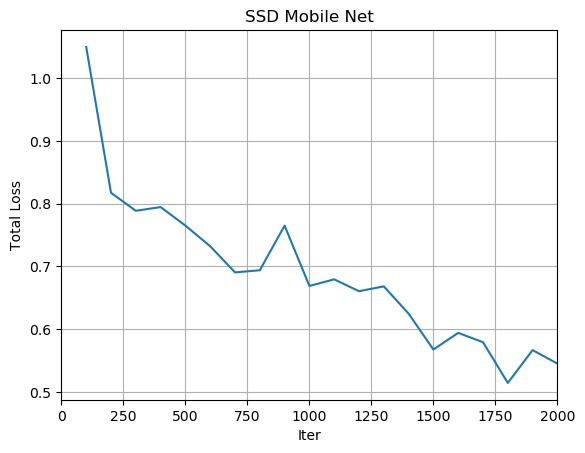

In [13]:
%matplotlib inline
import cv2
import matplotlib.pyplot as plt
import numpy as np

plt.figure()
plt.plot(np.arange(100,2001,100), np.array([1.0499,0.8174,0.7887,0.7946,0.7651,0.7322,0.6905,0.6939,0.765,0.6689,0.6794,0.6605,0.6682,0.6248,0.5675,0.5941,0.5792,0.5143,0.5666,0.5451]))
plt.xlabel('Iter');
plt.ylabel('Total Loss');
plt.title('SSD Mobile Net');
plt.xlim([0,2000])
plt.grid()

Looking at the validation frames, one immediately notices that there are too many overlapping boxes. Perhaps some tuning of the non-max suppression would also benefit.

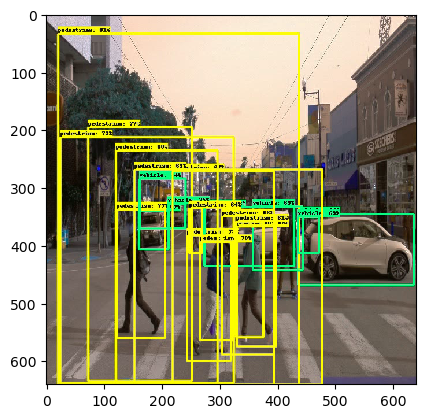

In [5]:
ani = cv2.VideoCapture('../data/output-ssd.avi')
plt.figure(1)

ret = 1
count = 0
while ret:
    ret, frame = ani.read()    
    
    if ret and count==79:
        plt.imshow(frame)
        plt.draw()
    count += 1

